<!--NOTEBOOK_INFORMATION-->
<img id="r-1060983" data-claire-element-id="1061343" src="http://www.siteduzero.com/favicon.ico" alt="Image utilisateur">
    <p>
        **<font color='#D2691E'size="6">Tags recommendation (4/7)</font>**.
    </p>
    

<p>
    This notebook explores the LDA unsupervised method in order to build matrices of similarities between words that will allow relevant tags recommendation.
</p>

<p>
    The LDA allows to build topics distributions for each message.
</p>


<p>
    The LDA also gives words pseudo-counts for each of its components
</p>


<p>
    I normalize the words pseudo-counts on the LDA components in order to get their weights in the topics space.
</p>

<p>
    I can then find similar words to each words and store them in a matrices of similarities :
</p>

<p>
    --> A matrix of similarities of all words
</p>

<p>
    --> A matrix of similarities focused on tags
</p>

<p>
    The final recommendation is based on this two matrices
</p>

<p>
    <center>
        **<font color='	#D2691E'size="6">PLAN</font>**
    </center>
</p>

<p>
        **<font color='#D2691E'size="4">0) Libraries, functions and datasources import</font>**
</p>
<p>
        **<font color='#D2691E'size="4">I) LDA Implementation</font>**
</p>
<p>
        **<font color='#D2691E'size="4">II) Topics distributions for the corpus elements</font>**
</p>
<p>
        **<font color='#D2691E'size="4">III) Topics associated to words</font>**
</p>
<p>
        **<font color='#D2691E'size="4">IV) Words associated to Topics</font>**
</p>
<p>
        **<font color='#D2691E'size="4">V) Tags associated to topics</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VI) Building the LDA word/tags similarities matrices</font>**
</p>
<p>
        **<font color='#D2691E'size="4">VII) Topics management</font>**
</p>
<p>
        **<font color='#D2691E'size="4">IX) LDA main topics</font>**
</p>
<p>
        **<font color='#D2691E'size="4">X) Generating tags</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XI) CHECKS on the train perimeter</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XII) Prediction on the test data</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XIII) Tags generation on the test perimeter</font>**
</p>
<p>
        **<font color='#D2691E'size="4">XIV) CHECKS on the test perimeter</font>**
</p>

<p>
        **<font color='#D2691E'size="4">0) Library, functions and datasources import </font>**
</p>

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [2]:
from context import dir_path, datasources_path, enrichment_path, pickles_path, temp_files_path

In [3]:
from functions import aggregate_col_in_list

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [5]:
df_model= pickle.load(open(pickles_path+"df_model_unsupervised.p", "rb" ))
df_model.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score
0,0,while applying opacity to a form should we use...,"[csharp, winforms]",apply opacity form use decimal double value us...,29,21,2,{},0,0.000000
1,1,percentage width child element in absolutely p...,"[html, css, internetexplorer7]",percentage width child element absolutely posi...,44,23,3,{css},1,0.333333
2,2,how do i calculate someone age in csharp given...,"[net, csharp, datetime]",calculate age csharp datetime represent person...,9,7,3,"{datetime, csharp}",2,0.666667
3,3,calculate relative time in csharp given a spec...,"[datetime, csharp]",calculate relative time csharp datetime value ...,16,12,2,"{datetime, csharp}",2,1.000000
4,4,determine a user timezone is there any standar...,"[javascript, browser, html]",determine user timezone web server determine u...,14,10,3,{},0,0.000000


In [6]:
L_train_indexes = pickle.load(open(pickles_path+"L_train_indexes.p", "rb" ))
L_test_indexes = pickle.load(open(pickles_path+"L_test_indexes.p", "rb" ))

In [7]:
L_frequent_tags = pickle.load(open(pickles_path+"L_frequent_tags.p", "rb" ))

In [8]:
df_train = df_model[df_model['id'].isin(L_train_indexes)]
df_test = df_model[df_model['id'].isin(L_test_indexes)]

<p>
        **<font color='#D2691E'size="4">I) LDA Implementation</font>**
</p>

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

In [10]:
L_corpus = list(df_train['corpus'])

In [11]:
L_corpus[0:5]

['percentage width child element absolutely position parent internet explorer 7 absolutely position div children relatively position div use width child div collapse width internet explorer 7 firefox safari use pixel width parent relatively position percentage width child besides width child area css specification cover',
 'calculate age csharp datetime represent person calculate age year',
 'calculate relative time csharp datetime value relative time like 2 hour ago 3 ago month ago',
 'msdnmicrosoftcom enus library msdnmicrosoftcom enus library net',
 'fill dataset datatable linq query set expose linq query asmx web service usually business tier return type dataset datatable serialize transport asmx linq query populate type dataset datatable linq query public static string db new new sproc linq var query dr select dr copy linq query resultset datatable return get set linq query dataset datatable alternatively linq query expose asmx web service']

In [12]:
len(L_corpus)

3939

In [13]:
N_FEATURES = 1000
N_TOP_WORDS = 20
N_COMPONENTS = 10

In [14]:
# Use count (raw term count) features for LDA.
print("Extracting count features for LDA...")
count_vectorizer = CountVectorizer(max_df=0.95, min_df=10, max_features=N_FEATURES)
start_time = time.time()
count = count_vectorizer.fit_transform(L_corpus)
print("--- %s seconds ---" % (time.time() - start_time))

Extracting count features for LDA...
--- 0.1436152458190918 seconds ---


In [15]:
lda = LatentDirichletAllocation(n_components=N_COMPONENTS, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
start_time = time.time()
lda.fit(count)
print("--- %s seconds ---" % (time.time() - start_time))

print("\nTopics in LDA model:")
vectorizer_feature_names = count_vectorizer.get_feature_names()
print_top_words(lda, vectorizer_feature_names, N_TOP_WORDS)

--- 6.246647119522095 seconds ---

Topics in LDA model:
Topic #0: array ruby session size number print tags perl using option rails menu reference tag iphone cost count like filter openid
Topic #1: user application use log users using access net get like update directory store login error machine expression regex web problem
Topic #2: class public use like csharp thread new using interface object library design method code static language private methods java objects
Topic #3: database sql data table server query list select like key use tables using mysql change set get stored db field
Topic #4: javascript form html text button browser image page like use css using code content firefox user get tag div jquery
Topic #5: use visual control build get studio windows code application using file like version problem app net program process project time
Topic #6: web service development use project using start testing windows document time email developer experience get python services envir

In [16]:
#Thanks to the "vectorizer_feature_names" column we can now make a DataFrame which contains the schema of the training words space
#We will need this schema in order to work with the test datas.
df_train_words_space_schema = pd.DataFrame(columns = vectorizer_feature_names)
df_train_words_space_schema

,09,10,100,11,12,15,2000,2003,2005,2007,...,wouldnt,wpf,wrap,xml,xp,year,yes,yet,youre,zip


<p>
        **<font color='#D2691E'size="4">II) Topics distributions for the corpus elements</font>**
</p>

In [17]:
results = lda.transform(count)
results[0:10]

array([[0.00312506, 0.00312509, 0.00312524, 0.00312507, 0.97187407,
        0.00312512, 0.00312509, 0.00312509, 0.00312505, 0.00312512],
       [0.0125    , 0.01250008, 0.2606771 , 0.01250146, 0.01250041,
        0.01250036, 0.01250097, 0.63931254, 0.01250676, 0.01250031],
       [0.00769284, 0.00769272, 0.00769358, 0.00769325, 0.00769275,
        0.00769304, 0.5227736 , 0.41568238, 0.00769282, 0.00769301],
       [0.0125    , 0.01250191, 0.88749234, 0.0125    , 0.01250001,
        0.01250116, 0.01250097, 0.01250044, 0.01250057, 0.01250261],
       [0.00212771, 0.00212805, 0.10448136, 0.65946818, 0.00212788,
        0.00212781, 0.11094395, 0.11233928, 0.00212793, 0.00212784],
       [0.01250003, 0.01250182, 0.01250017, 0.88748844, 0.01250001,
        0.01250003, 0.0125    , 0.01250111, 0.01250001, 0.0125084 ],
       [0.01000082, 0.01000521, 0.01000024, 0.90998078, 0.01000076,
        0.01000386, 0.01000014, 0.01000429, 0.01000206, 0.01000182],
       [0.01111588, 0.01111283, 0.0111132

In [18]:
L_main_topics = []
for sub_result in results:
    L_main_topics.append(np.argmax(sub_result))
L_main_topics[0:10]

[4, 7, 6, 2, 3, 3, 3, 7, 3, 2]

In [19]:
df_corpus_topics = pd.DataFrame(results)
df_corpus_topics['id'] = list(df_train['id'])
df_corpus_topics['main_topic'] = L_main_topics
df_corpus_topics['corpus'] = L_corpus
df_corpus_topics.head()

,0,1,2,3,4,5,6,7,8,9,id,main_topic,corpus
0,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,1,4,percentage width child element absolutely posi...
1,0.012500,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,2,7,calculate age csharp datetime represent person...
2,0.007693,0.007693,0.007694,0.007693,0.007693,0.007693,0.522774,0.415682,0.007693,0.007693,3,6,calculate relative time csharp datetime value ...
3,0.012500,0.012502,0.887492,0.012500,0.012500,0.012501,0.012501,0.012500,0.012501,0.012503,5,2,msdnmicrosoftcom enus library msdnmicrosoftcom...
4,0.002128,0.002128,0.104481,0.659468,0.002128,0.002128,0.110944,0.112339,0.002128,0.002128,6,3,fill dataset datatable linq query set expose l...


In [20]:
L_topics = []
for topic in range(N_COMPONENTS):
    L_topics.append(topic)

<p>
        **<font color='#D2691E'size="4">III) Topics associated to words</font>**
</p>

In [21]:
df_topics_words = pd.DataFrame(lda.components_, columns=vectorizer_feature_names)
df_topics_words

,09,10,100,11,12,15,2000,2003,2005,2007,...,wouldnt,wpf,wrap,xml,xp,year,yes,yet,youre,zip
0,0.103474,0.107576,20.737489,0.103116,0.136588,0.770526,0.103119,0.135065,0.103687,0.105382,...,0.110380,0.102807,0.103060,0.107050,0.103065,0.127212,6.643383,5.294577,0.113076,0.113238
1,33.865200,10.515539,0.531688,45.372411,0.167440,1.478246,1.156856,2.630512,0.109022,3.974220,...,3.062500,0.494370,0.606119,6.931727,2.338900,1.198486,7.634270,2.884173,3.167534,1.966990
2,0.105798,0.309782,0.572635,0.107795,12.448043,0.110231,0.136871,0.104785,0.120630,2.605401,...,14.581565,16.127666,7.613787,0.249964,0.104479,4.520195,7.028190,23.820139,13.979300,0.123963
3,0.102993,20.410050,1.557704,5.504171,16.312033,14.869995,36.042196,0.113860,119.389924,0.113412,...,4.315596,0.114016,0.118886,5.945345,0.134577,7.888052,5.182785,7.648985,6.553722,0.202632
4,0.199546,16.066649,11.571985,0.109271,5.738387,0.103615,0.103074,0.103518,0.103257,7.701724,...,0.819856,14.369279,21.321582,16.299960,0.142305,0.640359,1.943686,2.772696,0.122471,0.103053
5,0.113853,2.664549,0.131774,5.009105,0.185448,4.454349,0.154246,0.252354,88.198587,34.422479,...,10.156694,86.789524,0.224232,0.379325,10.499890,16.050709,19.166448,24.325807,4.802710,32.517486
6,0.294342,0.246386,3.099869,0.108541,0.164583,4.947371,0.103820,54.503041,6.915169,14.427719,...,0.247926,0.103605,0.249042,10.516880,65.272471,34.743064,0.551828,7.873808,1.478388,0.105644
7,0.112561,43.015345,5.053899,11.664854,8.292029,14.045323,0.103751,0.110855,0.111186,0.105826,...,1.881380,0.103778,7.532165,90.725047,0.106554,42.017342,1.853784,0.114410,0.335549,2.138683
8,0.102854,8.668551,0.103848,0.109000,0.127229,0.103650,0.105601,0.104766,0.103136,0.578521,...,4.804041,0.115740,0.112948,0.113581,0.105616,0.105959,0.103910,0.445785,0.352646,0.105085
9,0.110476,23.339465,8.587382,4.404695,1.731505,0.175872,7.461443,0.351514,4.696005,0.292572,...,7.083296,0.115250,15.206358,152.171550,9.347358,6.600883,9.889462,18.722353,15.258600,0.121741


In [22]:
#We can see that the topics weights in the words space are not normalized : 
#belong the sklearn documentation (http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
#the "components_" attribute can be viewed as pseudocount that represents the number of times word j was assigned to topic i.
#It can also be viewed as distribution over the words for each topic after normalization
#=> I choose to normalize the pseudo-counts of each words over the topics in order to get the weight of each topic for words
for column in df_topics_words.columns:
    column_sum = np.sum(df_topics_words[column])
    df_topics_words[column] = df_topics_words[column].apply(lambda x : x/column_sum)

<p>
        **<font color='#D2691E'size="4">IV) Words associated to Topics</font>**
</p>

In [23]:
df_words_topics = df_topics_words.T
df_words_topics.head()

,0,1,2,3,4,5,6,7,8,9
09,0.002947,0.964516,0.003013,0.002933,0.005683,0.003243,0.008383,0.003206,0.002929,0.003146
10,0.000858,0.083894,0.002471,0.162832,0.128181,0.021258,0.001966,0.343179,0.069158,0.186203
100,0.399195,0.010235,0.011023,0.029986,0.222760,0.002537,0.059672,0.097287,0.001999,0.165306
11,0.001422,0.625887,0.001487,0.075927,0.001507,0.069098,0.001497,0.160910,0.001504,0.060760
12,0.003015,0.003696,0.274771,0.360063,0.126666,0.004093,0.003633,0.183034,0.002808,0.038220


In [24]:
df_topics_words['sql']

0    0.000142
1    0.000757
2    0.000234
3    0.994193
4    0.000196
5    0.000170
6    0.000235
7    0.000158
8    0.000183
9    0.003733
Name: sql, dtype: float64

In [25]:
df_words_topics[3].sort_values(ascending=False).head()

table           0.997024
sql             0.994193
tables          0.993813
foreign         0.984466
relationship    0.982640
Name: 3, dtype: float64

In [26]:
df_words_topics.loc[L_frequent_tags,].head()

c:\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9
csharp,0.000532,0.019604,0.446732,0.042958,0.014183,0.073891,0.098253,0.159410,0.041774,0.102663
net,0.000177,0.249168,0.111414,0.001110,0.001884,0.287819,0.141848,0.063025,0.047890,0.095665
aspnet,0.000226,0.117219,0.000305,0.000395,0.001004,0.041626,0.000391,0.000344,0.829655,0.008834
java,0.004251,0.039270,0.311857,0.000237,0.014025,0.000528,0.073050,0.022619,0.031553,0.502609
sqlserver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#We can see that some tags don't have weights : it must be dued to the splitting in train and test
L_matching_lda_tags = [word for word in df_words_topics.index if word in L_frequent_tags]
L_missing_lda_tags = [word for word in L_frequent_tags if not word in L_matching_lda_tags]

print("The LDA model has %s tags coordinates in the topics space | %s tags are missing"%(len(L_matching_lda_tags),len(L_missing_lda_tags)))

The LDA model has 121 tags coordinates in the topics space | 144 tags are missing


In [28]:
#We need to have coordinates in the topic space for each tag, so we are going to look after the missing information thanks to
#The original tag_list present in the DataFrame.

<p>
        **<font color='#D2691E'size="4">V) Tags associated to topics</font>**
</p>

<p>We want to denormalize our entry dataframe thanks to the 'tag_list' column :</p>
<img align="left" style="padding-right:10px;" src="./images/develop_illustration.jpg">

In [29]:
#We specify the excution params for  the python script responsible for the multiprocessing : 
execution_params = {'N_PROCS' : 6,
                    'dataframe':df_train[['tag_list','id']],
                   'column_to_develop':'tag_list'}
#We dump our execution params :
pickle.dump(execution_params,open(temp_files_path+"execution_params.p", "wb"))
#And we run the script responsible for the stopwords elimination on different process :  
%run -i multiprocessing_develop.py


#We load the result of the multiprocessing task : 
developped_dataframe = pickle.load(open(temp_files_path+"developped_dataframe.p", "rb" ))

#We clean the temp files dir :
import os
from functions import class_my_files
dict_extensions = class_my_files(temp_files_path)
pickles_temp_files  = dict_extensions['p']
for file_name in pickles_temp_files:
    os.remove(temp_files_path+file_name)

developped_dataframe.sort_values(by='id', inplace=True)
developped_dataframe.rename({'tag_list':'tag'}, axis=1, inplace=True)
developped_dataframe.head()

Multiprocessing
Creating pool with 6 processes

df_append
df_append
df_append
df_append
df_append
df_append
--- 6.040757894515991 seconds ---
the result file is available at : 
 temp_files_path+"developped_dataframe.p"


,tag,id
0,html,1
2,internetexplorer7,1
1,css,1
5,datetime,2
4,csharp,2


In [30]:
#Now the dataframe is denormalized on the 'tag' column, we can compute the average topic weights for each tag :
global_df_corpus_topics = pd.merge(developped_dataframe,df_corpus_topics,how='left',on='id')
global_df_corpus_topics.head()

,tag,id,0,1,2,3,4,5,6,7,8,9,main_topic,corpus
0,html,1,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,percentage width child element absolutely posi...
1,internetexplorer7,1,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,percentage width child element absolutely posi...
2,css,1,0.003125,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,percentage width child element absolutely posi...
3,datetime,2,0.012500,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7,calculate age csharp datetime represent person...
4,csharp,2,0.012500,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7,calculate age csharp datetime represent person...


In [31]:
#We first parameter the list  of columns we need for the aggregation :
L_tags_topics = L_topics.copy()
L_tags_topics.append('tag')

In [32]:
#And we aggregate the topics weights on the dataframe's tags
df_tags_topics = global_df_corpus_topics[L_tags_topics].groupby('tag').mean()
df_tags_topics.head()

,0,1,2,3,4,5,6,7,8,9
tag,,,,,,,,,,
64bit,0.031127,0.149170,0.003142,0.028729,0.005670,0.264194,0.285542,0.023961,0.011874,0.196593
actionscript3,0.034123,0.071046,0.100050,0.057784,0.277214,0.102350,0.025715,0.191886,0.013283,0.126547
activedirectory,0.008740,0.524133,0.042735,0.100119,0.007805,0.124921,0.052741,0.045984,0.039258,0.053565
adobe,0.032825,0.006366,0.006365,0.136257,0.388216,0.081826,0.062084,0.036926,0.006365,0.242770
adonet,0.004020,0.089594,0.197186,0.296761,0.024191,0.004020,0.041592,0.063265,0.033978,0.245393


In [33]:
for tag in df_tags_topics.index:
    row_sum = np.sum(df_tags_topics.loc[tag,])
    df_tags_topics.loc[tag,] = df_tags_topics.loc[tag,]/row_sum
df_tags_topics.head()

,0,1,2,3,4,5,6,7,8,9
tag,,,,,,,,,,
64bit,0.031127,0.149170,0.003142,0.028729,0.005670,0.264194,0.285542,0.023961,0.011874,0.196593
actionscript3,0.034123,0.071046,0.100050,0.057784,0.277214,0.102350,0.025715,0.191886,0.013283,0.126547
activedirectory,0.008740,0.524133,0.042735,0.100119,0.007805,0.124921,0.052741,0.045984,0.039258,0.053565
adobe,0.032825,0.006366,0.006365,0.136257,0.388216,0.081826,0.062084,0.036926,0.006365,0.242770
adonet,0.004020,0.089594,0.197186,0.296761,0.024191,0.004020,0.041592,0.063265,0.033978,0.245393


In [34]:
#Finally, the dataframe mapping all tags to their topics weights is :
df_tags_topics = df_tags_topics.loc[L_missing_lda_tags,].append(df_words_topics.loc[L_matching_lda_tags,])
df_tags_topics.head()

,0,1,2,3,4,5,6,7,8,9
sqlserver,0.011851,0.060632,0.021977,0.575279,0.013844,0.047210,0.055897,0.091541,0.017984,0.103786
c++,0.023791,0.046935,0.215839,0.049857,0.036069,0.231474,0.064910,0.149457,0.025507,0.156159
visualstudio,0.015664,0.062068,0.063432,0.041318,0.038426,0.559604,0.090620,0.033648,0.018424,0.076797
c,0.063882,0.037204,0.098559,0.038167,0.045540,0.211660,0.078846,0.281369,0.020066,0.124706
languageagnostic,0.065277,0.042495,0.260128,0.098890,0.061605,0.068292,0.100924,0.137312,0.035664,0.129412


In [35]:
#And we can now append the missing tags in the dataframe which maps all words to their topics : 
df_words_topics = df_words_topics.append(df_tags_topics.loc[L_missing_lda_tags,])
df_words_topics.head()

,0,1,2,3,4,5,6,7,8,9
09,0.002947,0.964516,0.003013,0.002933,0.005683,0.003243,0.008383,0.003206,0.002929,0.003146
10,0.000858,0.083894,0.002471,0.162832,0.128181,0.021258,0.001966,0.343179,0.069158,0.186203
100,0.399195,0.010235,0.011023,0.029986,0.222760,0.002537,0.059672,0.097287,0.001999,0.165306
11,0.001422,0.625887,0.001487,0.075927,0.001507,0.069098,0.001497,0.160910,0.001504,0.060760
12,0.003015,0.003696,0.274771,0.360063,0.126666,0.004093,0.003633,0.183034,0.002808,0.038220


<p>
        **<font color='#D2691E'size="4">VI) Building the LDA word/tags similarities matrices</font>**
</p>

In [36]:
#With this two dataframes, we can compute the similarities between tags and words (with tags) in the topic's space:
X_tags_topics = df_tags_topics.values
X_word_topics = df_words_topics.values
from sklearn.metrics.pairwise import cosine_similarity

df_lda_tags_similarity = pd.DataFrame(cosine_similarity(X_tags_topics),columns=df_tags_topics.index, index=df_tags_topics.index)
df_lda_words_similarity = pd.DataFrame(cosine_similarity(X_word_topics),columns=df_words_topics.index, index=df_words_topics.index)

In [37]:
df_lda_tags_similarity.head()

,sqlserver,c++,visualstudio,c,languageagnostic,versioncontrol,unittesting,macos,userinterface,aspnetmvc,...,validation,vb6,vbnet,video,wcf,windows,winforms,workflow,wpf,xml
sqlserver,1.000000,0.343175,0.207167,0.333305,0.457171,0.315944,0.345513,0.289998,0.220926,0.254977,...,0.037908,0.097280,0.508652,0.050740,0.096282,0.182735,0.184472,0.127091,0.088981,0.268677
c++,0.343175,1.000000,0.747058,0.892837,0.881959,0.745157,0.721514,0.835729,0.836862,0.429640,...,0.146916,0.619275,0.755952,0.603501,0.168044,0.703271,0.515373,0.563315,0.679011,0.554356
visualstudio,0.207167,0.747058,1.000000,0.666890,0.410205,0.684170,0.398127,0.958647,0.699894,0.329520,...,0.132457,0.963160,0.431964,0.199559,0.158931,0.920249,0.479650,0.846045,0.962594,0.165533
c,0.333305,0.892837,0.666890,1.000000,0.765371,0.662235,0.591316,0.745861,0.648888,0.371468,...,0.173490,0.587419,0.535274,0.298628,0.198909,0.634394,0.424024,0.536208,0.569955,0.644169
languageagnostic,0.457171,0.881959,0.410205,0.765371,1.000000,0.574258,0.778987,0.565519,0.791963,0.459303,...,0.196112,0.223641,0.824042,0.722515,0.275485,0.408931,0.411074,0.323474,0.332552,0.529002


In [38]:
df_lda_words_similarity.head()

,09,10,100,11,12,15,2000,2003,2005,2007,...,internetexplorer7,lucene,operatingsystem,passwords,vbscript,linker,recursion,dns,ssis,triggers
09,1.000000,0.191335,0.028548,0.954189,0.014207,0.075646,0.035142,0.056962,0.005690,0.111223,...,0.133834,0.054271,0.063767,0.690061,0.030360,0.013717,0.119962,0.279372,0.015320,0.174229
10,0.191335,1.000000,0.434703,0.444707,0.633274,0.765198,0.441860,0.019146,0.328728,0.127770,...,0.377166,0.650319,0.242591,0.529596,0.674738,0.235644,0.841510,0.393398,0.544832,0.466200
100,0.028548,0.434703,1.000000,0.108148,0.267014,0.231066,0.130685,0.125615,0.068148,0.147661,...,0.488423,0.192781,0.283226,0.474036,0.260173,0.149825,0.382973,0.147793,0.359085,0.116670
11,0.954189,0.444707,0.108148,1.000000,0.187356,0.327357,0.162894,0.050025,0.159073,0.195996,...,0.142884,0.250010,0.161720,0.744624,0.230555,0.153765,0.386005,0.339439,0.158507,0.321221
12,0.014207,0.633274,0.267014,0.187356,1.000000,0.734270,0.715556,0.011806,0.579659,0.101466,...,0.328999,0.827153,0.160681,0.243595,0.566554,0.185881,0.640497,0.224272,0.449535,0.712598


In [39]:
def find_similar_words(similarity_matrix, list_of_terms, number_of_neighbors):
    """
    This function goal is to find similar words for each specific word contained in a list
    It returns a dictionary that maps each word of the list to its more similar neighbors
    - 'similarity_matrix' [pandas.DataFrame]  : A similarity matrix between words
    - 'list_of_terms' [list] : The list of words to use in order to search their neighbors
    - 'number_of_neighbors' [int] : The number of similar words to look for each word contained in "list_of_terms"
    """
    import numpy as np
    L_entities = list(similarity_matrix.index)
    L_indexes = list(range(0,len(L_entities)))
    dict_index_entity = {}
    
    for index, entity in zip(L_indexes,L_entities):
        dict_index_entity[index] = entity
    
    dict_neighbors = {}
    
    for term in list_of_terms:
        L_neighbors = []
        similar_terms = list(similarity_matrix.loc[term,])
        L_neigbors_indexes = sorted(range(len(similar_terms)), key=lambda i: similar_terms[i], reverse=True)[:number_of_neighbors+1]
    
        for index in L_neigbors_indexes:
            entity = dict_index_entity[index]
            if entity!=term:
                L_neighbors.append(entity)
        dict_neighbors[term] = L_neighbors
        
    return(dict_neighbors)

In [40]:
pd.DataFrame(find_similar_words(df_lda_tags_similarity,['c', 'file','database','sql','python','javascript','java'],10))

,c,database,file,java,javascript,python,sql
0,recursion,dataset,filesystems,codereview,flex,webservices,dataset
1,compactframework,mysql,ftp,fileio,flash,architecture,mysql
2,c++,sql,excel,networking,firefox,agile,database
3,cocoa,oracle,configuration,sockets,jquery,objectivec,oracle
4,commandline,storedprocedures,backup,tdd,css,unittesting,storedprocedures
5,xslt,sqlserver2005,git,soap,html,glossary,indexing
6,interop,databasedesign,networking,excel,unicode,resources,list
7,serialization,list,sockets,ftp,dom,projectmanagement,sqlserver2005
8,xcode,indexing,outlook,concurrency,validation,silverlight,databasedesign
9,net20,sqlserver,fileio,filesystems,ajax,concurrency,sqlserver


In [41]:
pd.DataFrame(find_similar_words(df_lda_words_similarity,['c', 'file','database','sql','python','javascript','java'],10))

,c,database,file,java,javascript,python,sql
0,code,join,commit,library,flex,br,tables
1,include,primary,drive,component,flash,suggest,table
2,recursion,procedure,files,msdn,button,future,foreign
3,manual,schema,filesystems,codereview,safari,tutorial,relationship
4,point,query,wait,operation,firefox,become,dataset
5,ignore,dataset,copy,everyone,textbox,technique,procedures
6,initial,procedures,port,checked,ltdiv,research,diff
7,compactframework,key,ftp,utility,typetext,course,schema
8,warn,diff,receive,embedded,jquery,webservices,procedure
9,get,mysql,mobile,remember,div,curious,query


In [42]:
df_corr = df_tags_topics.corr(method='spearman')

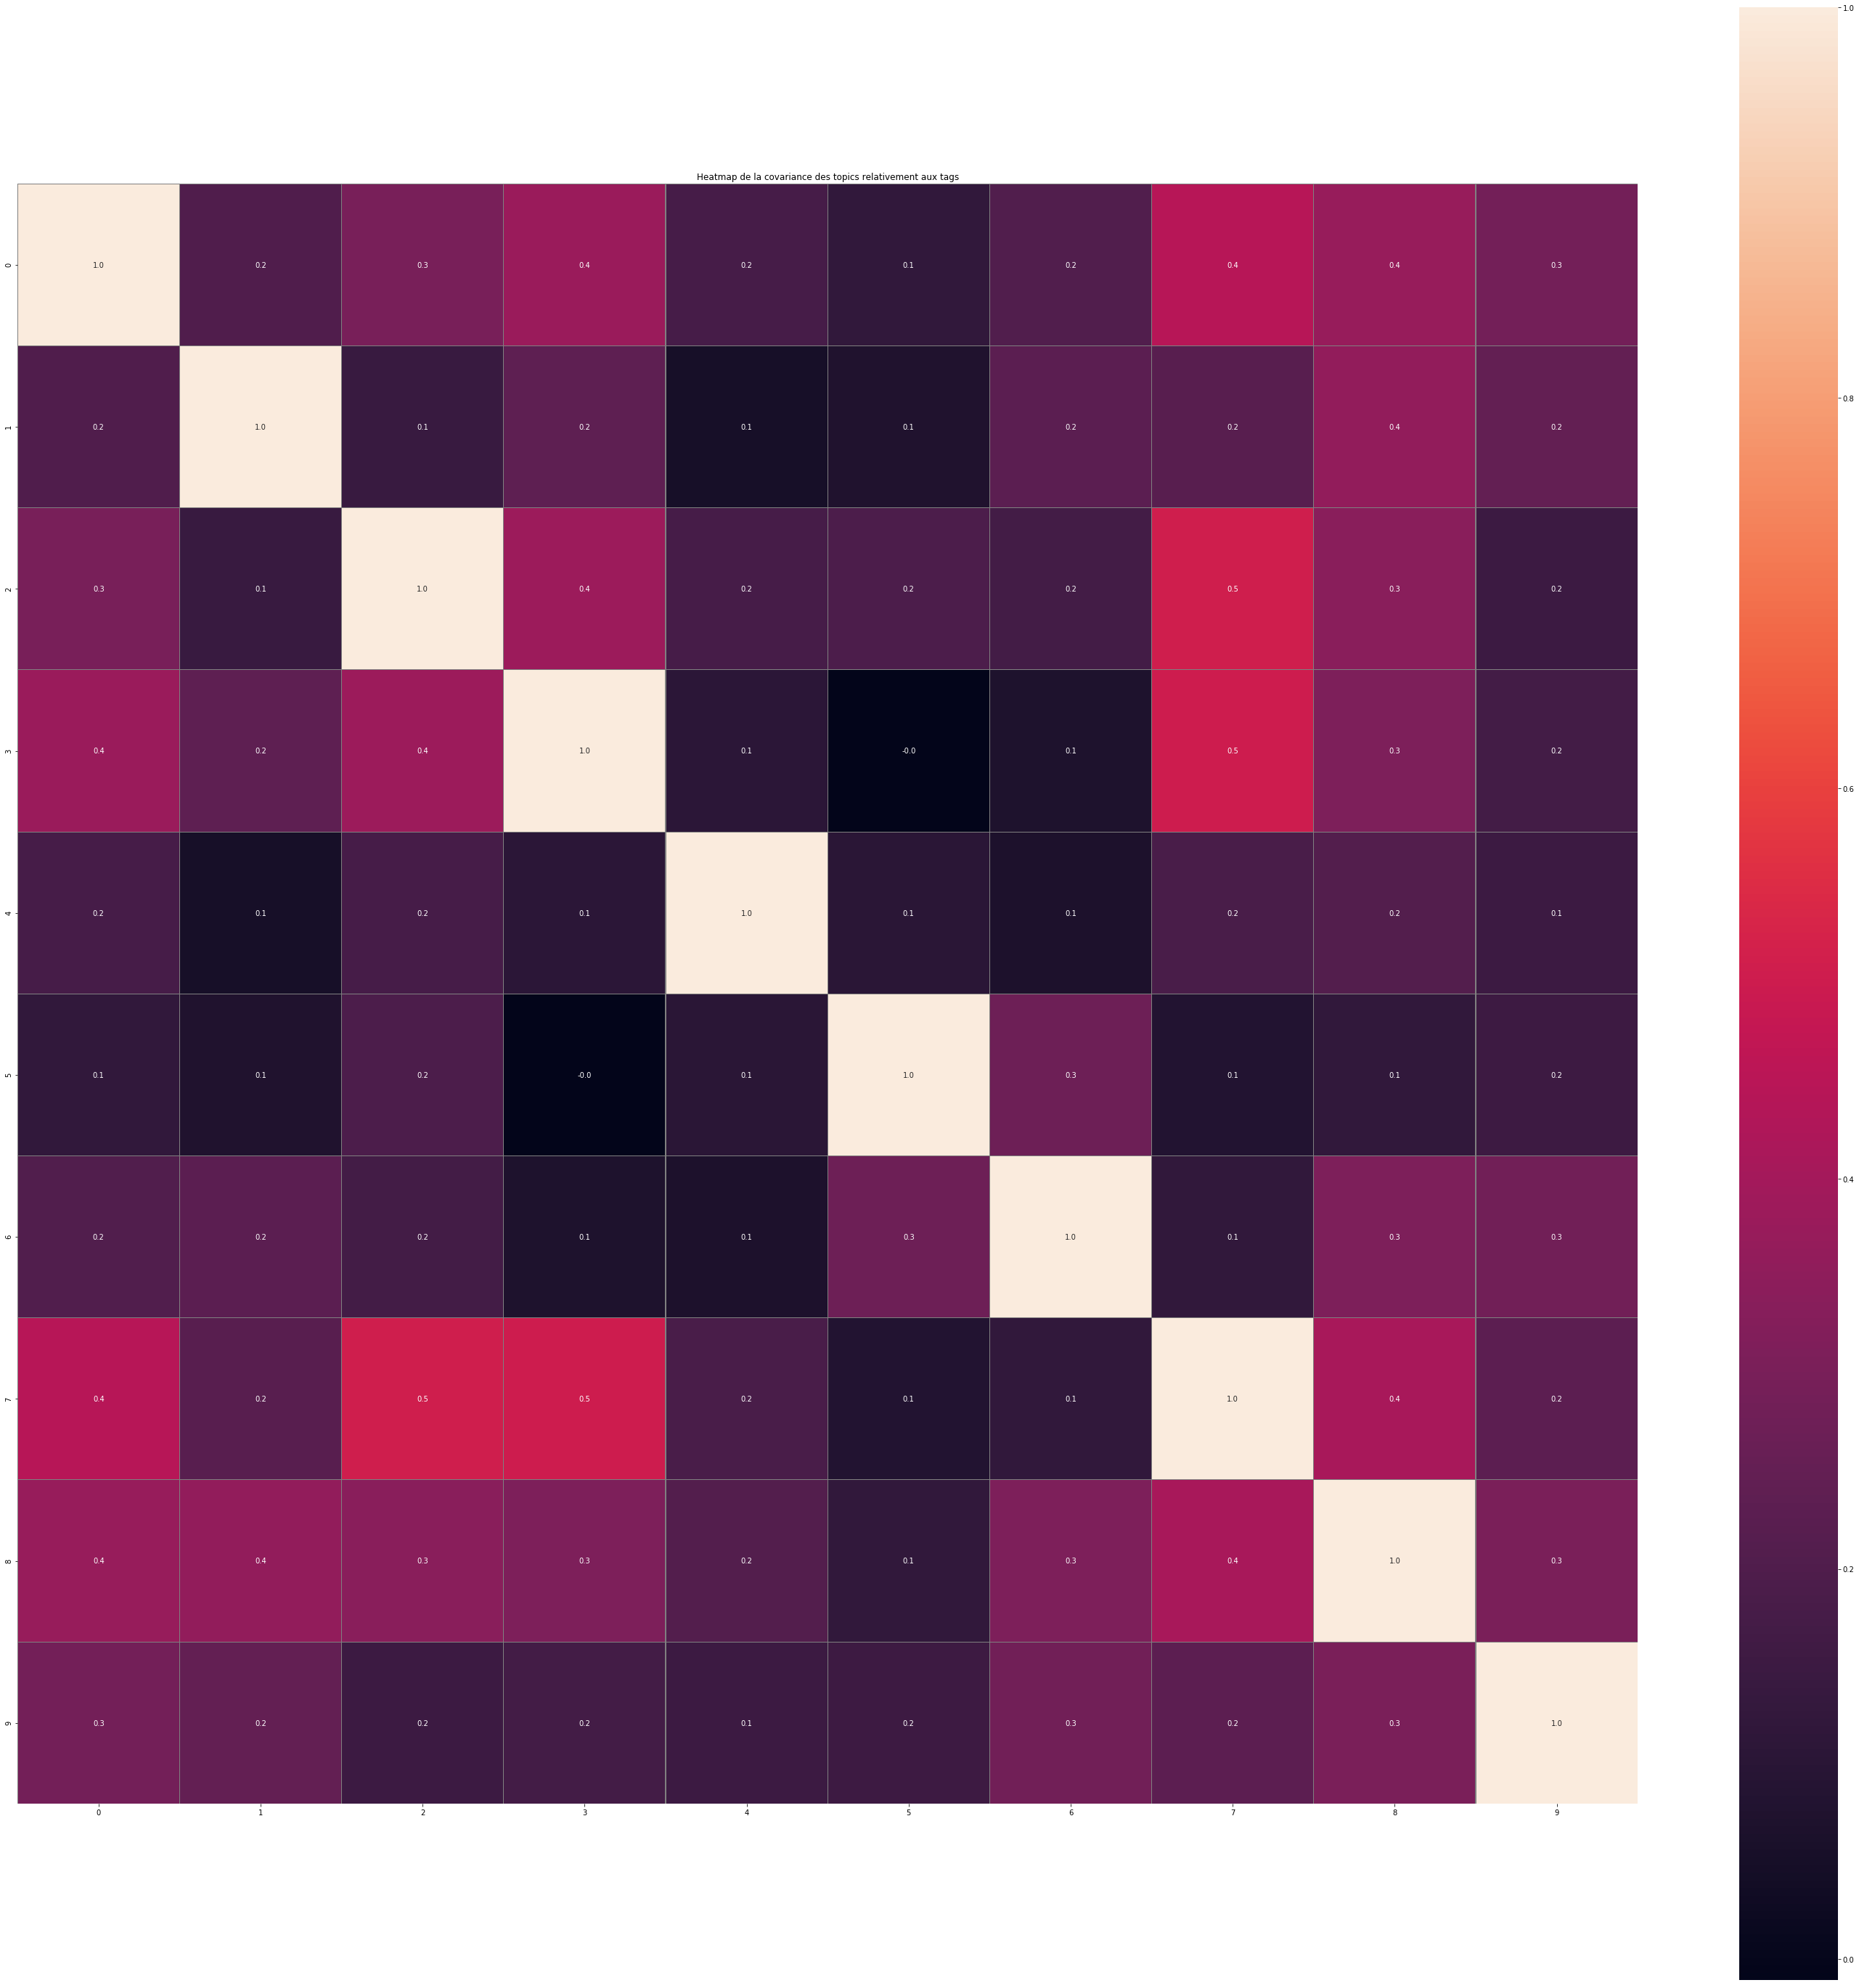

In [43]:
plt.figure(figsize=(50, 50))
sns.heatmap(df_corr,linecolor='grey' ,annot=True, linewidth=.1, fmt='.1f',square=True, cbar=True)
plt.title('Heatmap de la covariance des topics relativement aux tags')
plt.show()

<p>
        **<font color='#D2691E'size="4">VII) Topics management</font>**
</p>

In [44]:
THRESHOLD = 0.05
#THRESHOLD = 0.1

In [45]:
#We now want to build some dictionnaries that will map topics to the tags or words that have a strong weight (>= THRESHOLD) : 
dict_topics_tags = {}
dict_topics_words = {}

for topic in L_topics:
    L_heavy_tags = list(df_tags_topics[df_tags_topics[topic]>=THRESHOLD].index)
    dict_topics_tags[topic] = L_heavy_tags
    
    L_heavy_words = list(df_words_topics[df_words_topics[topic]>=THRESHOLD].index)
    dict_topics_words[topic] = L_heavy_words

In [46]:
dict_topics_tags[0]

['c',
 'languageagnostic',
 'rubyonrails',
 'optimization',
 'datastructures',
 'functionalprogramming',
 'databasedesign',
 'objectivec',
 'cocoa',
 'opengl',
 'glossary',
 'math',
 'collections',
 'graphics',
 'indexing',
 'compilerconstruction',
 'sorting',
 'soap',
 'https',
 'ios',
 'fulltextsearch',
 'xhtml',
 'namespaces',
 'xsd',
 'fogbugz',
 'lambda',
 'interop',
 'passwords',
 'recursion',
 'algorithm',
 'api',
 'arrays',
 'iphone',
 'memory',
 'openid',
 'oracle',
 'pdf',
 'perl',
 'php',
 'python',
 'ruby',
 'session',
 'ssl',
 'tags',
 'ubuntu']

In [47]:
dict_topics_words[0]

['100',
 '32',
 'ability',
 'account',
 'algorithm',
 'amount',
 'anyway',
 'api',
 'appear',
 'array',
 'arrays',
 'article',
 'assume',
 'aware',
 'away',
 'bad',
 'bar',
 'blog',
 'book',
 'box',
 'building',
 'certain',
 'choose',
 'collection',
 'comment',
 'comments',
 'compare',
 'concept',
 'condition',
 'cost',
 'count',
 'def',
 'detail',
 'duplicate',
 'element',
 'equivalent',
 'exit',
 'explain',
 'filter',
 'flag',
 'foreach',
 'functionality',
 'graph',
 'helpful',
 'high',
 'hold',
 'hop',
 'icon',
 'implementation',
 'increase',
 'index',
 'integrate',
 'interested',
 'iphone',
 'items',
 'job',
 'learning',
 'love',
 'low',
 'maintain',
 'mark',
 'matter',
 'memory',
 'menu',
 'monitor',
 'nested',
 'next',
 'nodes',
 'none',
 'notice',
 'number',
 'objects',
 'online',
 'onto',
 'openid',
 'operator',
 'option',
 'oracle',
 'order',
 'others',
 'pdf',
 'perl',
 'php',
 'possibly',
 'post',
 'pre',
 'print',
 'programming',
 'provider',
 'python',
 'quick',
 'rails',


<p>
        **<font color='#D2691E'size="4">IX) LDA main topics</font>**
</p>

In [48]:
df_corpus_topics.drop('corpus', axis=1, inplace=True)

In [49]:
df_train = pd.merge(df_train,df_corpus_topics,how='left',on='id')
df_train.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score,...,1,2,3,4,5,6,7,8,9,main_topic
0,1,percentage width child element in absolutely p...,"[html, css, internetexplorer7]",percentage width child element absolutely posi...,44,23,3,{css},1,0.333333,...,0.003125,0.003125,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4
1,2,how do i calculate someone age in csharp given...,"[net, csharp, datetime]",calculate age csharp datetime represent person...,9,7,3,"{datetime, csharp}",2,0.666667,...,0.012500,0.260677,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7
2,3,calculate relative time in csharp given a spec...,"[datetime, csharp]",calculate relative time csharp datetime value ...,16,12,2,"{datetime, csharp}",2,1.000000,...,0.007693,0.007694,0.007693,0.007693,0.007693,0.522774,0.415682,0.007693,0.007693,6
3,5,difference between mathfloor and mathtruncate ...,"[net, math]",msdnmicrosoftcom enus library msdnmicrosoftcom...,7,4,2,{net},1,0.500000,...,0.012502,0.887492,0.012500,0.012500,0.012501,0.012501,0.012500,0.012501,0.012503,2
4,6,filling a dataset or datatable from a linq que...,"[webservices, net35, linq, csharp]",fill dataset datatable linq query set expose l...,62,31,4,{linq},1,0.250000,...,0.002128,0.104481,0.659468,0.002128,0.002128,0.110944,0.112339,0.002128,0.002128,3


In [50]:
df_train['lda_tags'] = df_train['main_topic'].apply(lambda x : dict_topics_tags[x])
df_train['lda_words'] = df_train['main_topic'].apply(lambda x : dict_topics_words[x])
df_train.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score,...,3,4,5,6,7,8,9,main_topic,lda_tags,lda_words
0,1,percentage width child element in absolutely p...,"[html, css, internetexplorer7]",percentage width child element absolutely posi...,44,23,3,{css},1,0.333333,...,0.003125,0.971874,0.003125,0.003125,0.003125,0.003125,0.003125,4,"[languageagnostic, macos, userinterface, aspne...","[10, 100, 12, 2007, accomplish, achieve, actio..."
1,2,how do i calculate someone age in csharp given...,"[net, csharp, datetime]",calculate age csharp datetime represent person...,9,7,3,"{datetime, csharp}",2,0.666667,...,0.012501,0.012500,0.012500,0.012501,0.639313,0.012507,0.012500,7,"[sqlserver, c++, c, languageagnostic, webservi...","[10, 100, 11, 12, 15, 30, 50, accept, access, ..."
2,3,calculate relative time in csharp given a spec...,"[datetime, csharp]",calculate relative time csharp datetime value ...,16,12,2,"{datetime, csharp}",2,1.000000,...,0.007693,0.007693,0.007693,0.522774,0.415682,0.007693,0.007693,6,"[sqlserver, c++, visualstudio, c, languageagno...","[100, 15, 2003, 2007, 2008, 30, 32, 64bit, acc..."
3,5,difference between mathfloor and mathtruncate ...,"[net, math]",msdnmicrosoftcom enus library msdnmicrosoftcom...,7,4,2,{net},1,0.500000,...,0.012500,0.012500,0.012501,0.012501,0.012500,0.012501,0.012503,2,"[c++, visualstudio, c, languageagnostic, unitt...","[12, ability, abstract, accept, access, accomp..."
4,6,filling a dataset or datatable from a linq que...,"[webservices, net35, linq, csharp]",fill dataset datatable linq query set expose l...,62,31,4,{linq},1,0.250000,...,0.659468,0.002128,0.002128,0.110944,0.112339,0.002128,0.002128,3,"[sqlserver, languageagnostic, unittesting, asp...","[10, 11, 12, 15, 2000, 2005, 2008, accept, acc..."


<p>
        **<font color='#D2691E'size="4">X) Generating tags</font>**
</p>

In [51]:
def generate_tags_lda(myText,
                  lda_word_sim_matrix,
                  lda_tag_sim_matrix,
                  existing_tags,
                  NEIGHBORS,
                  recommendation_filter,
                  THRESHOLD):
    """
    This function goal is to generate tags from words similarities matrices built with LDA
    We initialize an empty list 'L_recommendation'
    for all word in a given text :
        - Neighbor selection : Each matrix allows to find N neighbors of the word
        - Each neighbor computed is added to a 'L_recommendation' each time it is encountered by the "Neighbor selection"
    We then use a Counter in order to get each word occurences in 'L_recommendation'
    This Counter allows to dertermine the value occuences's quantile 'THRESHOLD'
    Finally the recommendation consists of : 
        - selecting the words with occurences > quantile[THRESHOLD]
        - proposing text words which are already tags
    
    PARAMETERS : 
    - 'lda_word_sim_matrix' : a matrix similarity between all words
    - 'lda_tag_sim_matrix' : a matrix similarity between all tags
    - 'existing_tags' : the existing tags of the stuty
    - 'NEIGHBORS' : the number of neighbors to look after in the matrices
    - 'recommendation_filter' : a filter of tags to use, since some of the "existing_tags" can be out of the train perimeter
    - 'THRESHOLD' 0 < [int] < 1 : The occurence threshold to use in terms of occurences's quantile
    
    """

    from collections import Counter
    import pandas as pd

    L_recommendation = []
    L_sim_matrices = [lda_word_sim_matrix,lda_tag_sim_matrix]
    L_labels = ['lda_word_sim_matrix','lda_tag_sim_matrix']

    corpus = myText.split(" ")
    matching_tags = set(corpus).intersection(set(existing_tags))
    for word in corpus:
        for sim_matrix,label in zip(L_sim_matrices,L_labels):
            if word in sim_matrix.index :
                matrix_recommendation = find_similar_words(sim_matrix,[word],NEIGHBORS)
                matrix_recommendation = matrix_recommendation[word]
                matrix_recommendation = list(set(matrix_recommendation).intersection(set(recommendation_filter)))
                L_recommendation+= matrix_recommendation

            else:
                matrix_recommendation = []
                L_recommendation+= matrix_recommendation

    all_models_counter = dict(Counter(L_recommendation))
    df_all_models_counter = pd.DataFrame(all_models_counter,index=['occurences']).T
    df_all_models_counter = df_all_models_counter.groupby(df_all_models_counter.index).sum()
    df_all_models_counter.sort_values(by='occurences', ascending=False, inplace=True)

    quantiles = df_all_models_counter['occurences'].quantile(q=[THRESHOLD])
    quantiles = quantiles.to_dict()

    df_all_models_counter = df_all_models_counter[df_all_models_counter['occurences']>=quantiles[THRESHOLD]]
    L_final_recommendation = set(list(df_all_models_counter.index)+list(matching_tags))

    return(L_final_recommendation)

In [52]:
start_time = time.time()

df_train['recommendation'] = df_train.apply(lambda x : generate_tags_lda(x['corpus'],
                                                                     df_lda_words_similarity,
                                                                     df_lda_tags_similarity,
                                                                     L_frequent_tags,
                                                                     5,
                                                                     x['lda_tags'],
                                                                     0.8),
                                            axis=1)


print("--- %s seconds ---" % (time.time() - start_time))
df_train['recommendation'][0:10]

--- 117.87878656387329 seconds ---


0                {jquery, css, firefox, html, unicode}
1           {csharp, datetime, oop, types, powershell}
2                     {datetime, cvs, eclipse, csharp}
3                       {net, java, refactoring, moss}
4    {dataset, postgresql, performance, string, lin...
5    {dataset, database, oracle, backup, mysql, sto...
6                                {dataset, mysql, sql}
7                       {cocoa, graphics, memory, vb6}
8    {dataset, net, database, csv, csharp, ssis, tr...
9    {net, moss, designpatterns, oop, types, inheri...
Name: recommendation, dtype: object

<p>
        **<font color='#D2691E'size="4">XI) CHECKS on the train perimeter</font>**
</p>

In [53]:
L_check_analysis = ['id','corpus','main_topic','text_len','tag_list','n_tags','tags_matching','matching_score','recommendation']

In [54]:
df_train[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation
0,1,percentage width child element absolutely posi...,4,44,"[html, css, internetexplorer7]",3,{css},0.333333,"{jquery, css, firefox, html, unicode}"
1,2,calculate age csharp datetime represent person...,7,9,"[net, csharp, datetime]",3,"{datetime, csharp}",0.666667,"{csharp, datetime, oop, types, powershell}"
2,3,calculate relative time csharp datetime value ...,6,16,"[datetime, csharp]",2,"{datetime, csharp}",1.000000,"{datetime, cvs, eclipse, csharp}"
3,5,msdnmicrosoftcom enus library msdnmicrosoftcom...,2,7,"[net, math]",2,{net},0.500000,"{net, java, refactoring, moss}"
4,6,fill dataset datatable linq query set expose l...,3,62,"[webservices, net35, linq, csharp]",4,{linq},0.250000,"{dataset, postgresql, performance, string, lin..."


In [55]:
df_train['n_tags_recommended'] = df_train.apply(lambda x : len(x['recommendation']),axis=1)
L_check_analysis.append('n_tags_recommended')
df_train[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation,n_tags_recommended
0,1,percentage width child element absolutely posi...,4,44,"[html, css, internetexplorer7]",3,{css},0.333333,"{jquery, css, firefox, html, unicode}",5
1,2,calculate age csharp datetime represent person...,7,9,"[net, csharp, datetime]",3,"{datetime, csharp}",0.666667,"{csharp, datetime, oop, types, powershell}",5
2,3,calculate relative time csharp datetime value ...,6,16,"[datetime, csharp]",2,"{datetime, csharp}",1.000000,"{datetime, cvs, eclipse, csharp}",4
3,5,msdnmicrosoftcom enus library msdnmicrosoftcom...,2,7,"[net, math]",2,{net},0.500000,"{net, java, refactoring, moss}",4
4,6,fill dataset datatable linq query set expose l...,3,62,"[webservices, net35, linq, csharp]",4,{linq},0.250000,"{dataset, postgresql, performance, string, lin...",7


In [56]:
df_train['matching_tags_train'] = df_train.apply(lambda x : set(x['recommendation']).intersection(set(x['tag_list'])), axis=1)
L_check_analysis.append('matching_tags_train')
df_train[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation,n_tags_recommended,matching_tags_train
0,1,percentage width child element absolutely posi...,4,44,"[html, css, internetexplorer7]",3,{css},0.333333,"{jquery, css, firefox, html, unicode}",5,"{html, css}"
1,2,calculate age csharp datetime represent person...,7,9,"[net, csharp, datetime]",3,"{datetime, csharp}",0.666667,"{csharp, datetime, oop, types, powershell}",5,"{datetime, csharp}"
2,3,calculate relative time csharp datetime value ...,6,16,"[datetime, csharp]",2,"{datetime, csharp}",1.000000,"{datetime, cvs, eclipse, csharp}",4,"{datetime, csharp}"
3,5,msdnmicrosoftcom enus library msdnmicrosoftcom...,2,7,"[net, math]",2,{net},0.500000,"{net, java, refactoring, moss}",4,{net}
4,6,fill dataset datatable linq query set expose l...,3,62,"[webservices, net35, linq, csharp]",4,{linq},0.250000,"{dataset, postgresql, performance, string, lin...",7,{linq}


In [57]:
df_train['matching_score_train'] = df_train.apply(lambda x : len(x['matching_tags_train'])/x['n_tags'], axis=1)
L_check_analysis.append('matching_score_train')
df_train[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation,n_tags_recommended,matching_tags_train,matching_score_train
0,1,percentage width child element absolutely posi...,4,44,"[html, css, internetexplorer7]",3,{css},0.333333,"{jquery, css, firefox, html, unicode}",5,"{html, css}",0.666667
1,2,calculate age csharp datetime represent person...,7,9,"[net, csharp, datetime]",3,"{datetime, csharp}",0.666667,"{csharp, datetime, oop, types, powershell}",5,"{datetime, csharp}",0.666667
2,3,calculate relative time csharp datetime value ...,6,16,"[datetime, csharp]",2,"{datetime, csharp}",1.000000,"{datetime, cvs, eclipse, csharp}",4,"{datetime, csharp}",1.000000
3,5,msdnmicrosoftcom enus library msdnmicrosoftcom...,2,7,"[net, math]",2,{net},0.500000,"{net, java, refactoring, moss}",4,{net},0.500000
4,6,fill dataset datatable linq query set expose l...,3,62,"[webservices, net35, linq, csharp]",4,{linq},0.250000,"{dataset, postgresql, performance, string, lin...",7,{linq},0.250000


In [58]:
np.mean(df_train['n_tags_recommended'])

9.256410256410257

In [59]:
np.median(df_train['n_tags_recommended'])

8.0

In [60]:
np.mean(df_train['matching_score_train'])

0.5777523906236777

In [61]:
np.median(df_train['matching_score_train'])

0.5

In [62]:
np.mean(df_train['matching_score'])

0.5321697554370821

In [63]:
np.median(df_train['matching_score'])

0.5

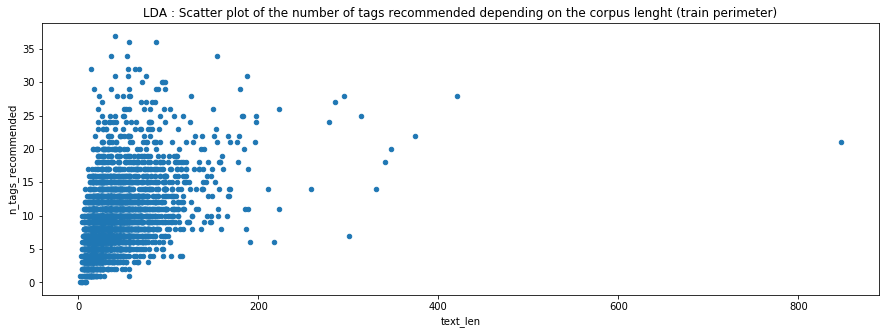

In [64]:
df_train.plot.scatter(x='text_len',
                     y='n_tags_recommended',
                     figsize=(15,5),
                     title = "LDA : Scatter plot of the number of tags recommended depending on the corpus lenght (train perimeter)")

In [65]:
import seaborn as sns

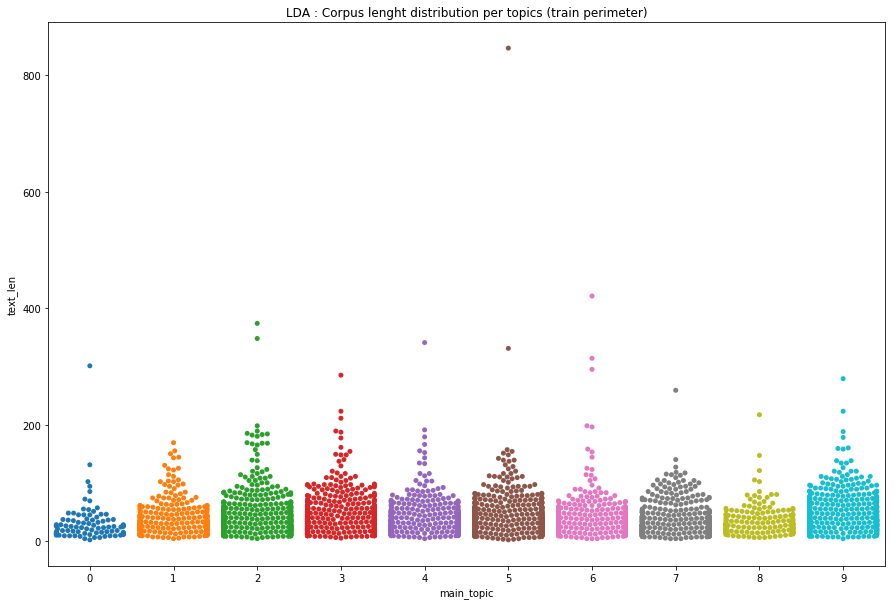

In [66]:
plt.figure(figsize=(15,10))
plt.title("LDA : Corpus lenght distribution per topics (train perimeter)")
ax = sns.swarmplot(x="main_topic", y="text_len", data=df_train)

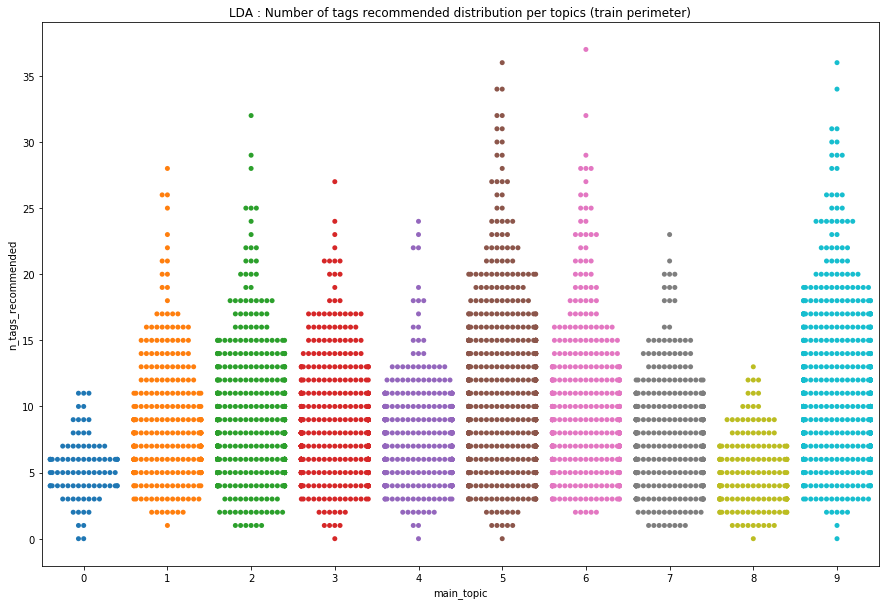

In [67]:
plt.figure(figsize=(15,10))
plt.title("LDA : Number of tags recommended distribution per topics (train perimeter)")
ax = sns.swarmplot(x="main_topic", y="n_tags_recommended", data=df_train)

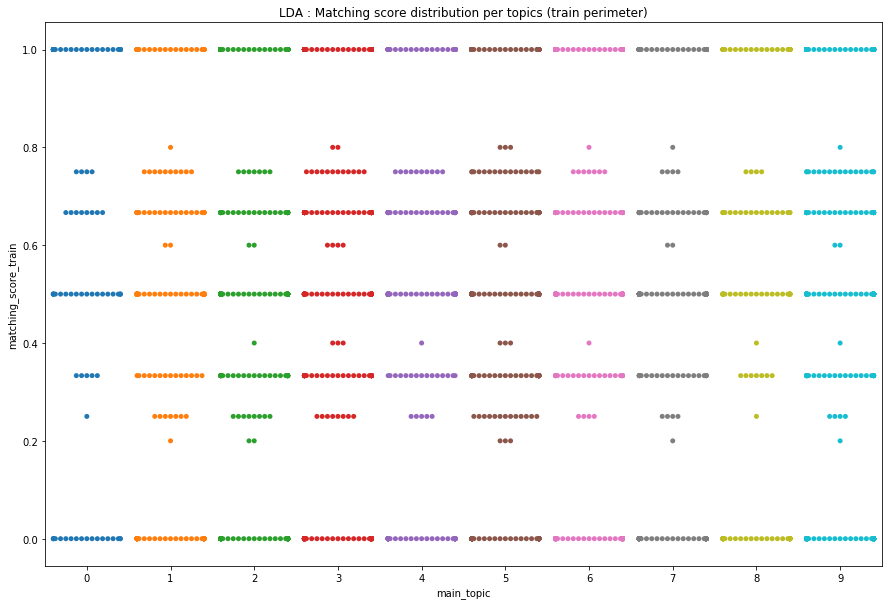

In [68]:
plt.figure(figsize=(15,10))
plt.title("LDA : Matching score distribution per topics (train perimeter)")
ax = sns.swarmplot(x="main_topic", y="matching_score_train", data=df_train)

<p>
        **<font color='#D2691E'size="4">XII) Prediction on the test data</font>**
</p>

In [69]:
df_test.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score
0,0,while applying opacity to a form should we use...,"[csharp, winforms]",apply opacity form use decimal double value us...,29,21,2,{},0,0.0
4,4,determine a user timezone is there any standar...,"[javascript, browser, html]",determine user timezone web server determine u...,14,10,3,{},0,0.0
8,8,what is the fastest way to get the value of π ...,"[performance, languageagnostic, unix, algorithm]",fast get value fast obtain value personal chal...,166,81,4,{},0,0.0
10,10,how to use the c socket api in c++ on z os ive...,"[sockets, c++, c]",use c socket api c++ z os get c sockets api pr...,87,64,3,"{c, c++, sockets}",3,1.0
19,19,how do i add existing comments to rdoc in ruby...,[ruby],add comments rdoc ruby format comments rdoc co...,15,10,1,{ruby},1,1.0


In [70]:
L_test_corpus = list(df_test['corpus'])

In [71]:
L_test_corpus[0:10]

['apply opacity form use decimal double value use change form opacity code decimal 5000 build application error implicitly type decimal double try using double control code past vbnet project',
 'determine user timezone web server determine user timezone web page perhaps http header string',
 'fast get value fast obtain value personal challenge specifically using involve using define constants like pi hardcoding number program tests various inline assembly version theory fast option clearly portable include compare versions tests version fast gcc constant specify version fast main testing program pitimesc pre prettyprintoverride include include ltstdioh include define define \\\\ diff 00 \\\\ clock \\\\ ++i \\\\ diff pi \\\\ clock \\\\ e time f diff \\\\ static inline double clock return double clock per sec int main int clock double diff case catch gcc folding pi use defined defined || defined extern double endif actual tests start return inline assembly x86 x64 systems pre double pi 

In [72]:
# Use count (raw term count) features for LDA in order to build the test bag of words :
print("Extracting count features for LDA...")
test_count_vectorizer = CountVectorizer(max_df=0.95, min_df=10, max_features=N_FEATURES)

start_time = time.time()
test_count = test_count_vectorizer.fit_transform(L_test_corpus)
test_vectorizer_feature_names = test_count_vectorizer.get_feature_names()
test_count_array = test_count.toarray()
df_all_test_words = pd.DataFrame(test_count_array, columns=test_vectorizer_feature_names)
print("--- %s seconds ---" % (time.time() - start_time))
df_all_test_words.head()

Extracting count features for LDA...
--- 0.048926353454589844 seconds ---


,10,100,11,2003,2005,2007,2008,30,35,50,...,worth,wouldnt,wpf,wrap,wrapper,xml,xp,year,yes,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
#We get back the train columns schema :
df_final_test_words = df_train_words_space_schema.copy()
df_final_test_words

,09,10,100,11,12,15,2000,2003,2005,2007,...,wouldnt,wpf,wrap,xml,xp,year,yes,yet,youre,zip


In [74]:
#The original shape is :
test_words_dim = df_all_test_words.shape[1]
print("Original test space words dimension is %s"%test_words_dim)
#But we have to filter the data onto the train space perimeter
df_all_test_words = df_all_test_words[[col for col in df_all_test_words.columns if col in list(df_final_test_words.columns)]]
test_words_dim = df_all_test_words.shape[1]
print("After filtering on the train columns perimeter, test space words dimension is %s"%test_words_dim)
df_all_test_words.head()

Original test space words dimension is 867
After filtering on the train columns perimeter, test space words dimension is 782


,10,100,11,2003,2005,2007,2008,30,35,50,...,world,worth,wouldnt,wpf,wrap,xml,xp,year,yes,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
#Finally, the test data looks like : 
df_final_test_words = df_final_test_words.append(df_all_test_words)
df_final_test_words.fillna(0, inplace=True)
df_final_test_words.head()

,09,10,100,11,12,15,2000,2003,2005,2007,...,wouldnt,wpf,wrap,xml,xp,year,yes,yet,youre,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
test_matrix = df_final_test_words.values

In [77]:
test_results = lda.transform(test_matrix)
test_results[0:10]

array([[0.00434807, 0.00434911, 0.08781023, 0.0043488 , 0.09639488,
        0.42775559, 0.0043485 , 0.36194649, 0.00434914, 0.00434918],
       [0.00769281, 0.2508292 , 0.00769257, 0.00769368, 0.00769405,
        0.00769298, 0.00769538, 0.17813937, 0.31667639, 0.20819356],
       [0.00125039, 0.0012503 , 0.05840585, 0.00125031, 0.03346398,
        0.18793918, 0.1204227 , 0.41044931, 0.00125019, 0.18431779],
       [0.00175482, 0.00175466, 0.09764169, 0.00175465, 0.00175472,
        0.48211304, 0.0017548 , 0.29818575, 0.00175462, 0.11153123],
       [0.39868784, 0.00769333, 0.00769344, 0.00769442, 0.23221317,
        0.00769374, 0.31523896, 0.0076952 , 0.00769534, 0.00769456],
       [0.00192329, 0.00192361, 0.18047021, 0.29567122, 0.00192331,
        0.03674604, 0.00192327, 0.4755723 , 0.00192324, 0.00192352],
       [0.00400047, 0.00400086, 0.00400167, 0.0040003 , 0.00400018,
        0.65127869, 0.00400128, 0.18129069, 0.00400015, 0.13942571],
       [0.00434894, 0.20095313, 0.0043490

In [78]:
test_results[0]

array([0.00434807, 0.00434911, 0.08781023, 0.0043488 , 0.09639488,
       0.42775559, 0.0043485 , 0.36194649, 0.00434914, 0.00434918])

In [79]:
L_test_main_topics = []
for sub_result in test_results:
    max_idx = np.argmax(sub_result)
    L_test_main_topics.append(np.argmax(sub_result))
L_test_main_topics[0:10]

[5, 8, 7, 5, 0, 7, 5, 5, 6, 8]

In [80]:
df_test_corpus_topics = pd.DataFrame(test_results)
df_test_corpus_topics['id'] = list(df_test['id'])
df_test_corpus_topics['main_topic'] = L_test_main_topics
df_test_corpus_topics.head()

,0,1,2,3,4,5,6,7,8,9,id,main_topic
0,0.004348,0.004349,0.087810,0.004349,0.096395,0.427756,0.004349,0.361946,0.004349,0.004349,0,5
1,0.007693,0.250829,0.007693,0.007694,0.007694,0.007693,0.007695,0.178139,0.316676,0.208194,4,8
2,0.001250,0.001250,0.058406,0.001250,0.033464,0.187939,0.120423,0.410449,0.001250,0.184318,8,7
3,0.001755,0.001755,0.097642,0.001755,0.001755,0.482113,0.001755,0.298186,0.001755,0.111531,10,5
4,0.398688,0.007693,0.007693,0.007694,0.232213,0.007694,0.315239,0.007695,0.007695,0.007695,19,0


In [81]:
df_test = pd.merge(df_test,df_test_corpus_topics,how='left',on='id')
df_test.head()

,id,Text,tag_list,corpus,text_len,unique_text_len,n_tags,tags_matching,n_tags_matching,matching_score,...,1,2,3,4,5,6,7,8,9,main_topic
0,0,while applying opacity to a form should we use...,"[csharp, winforms]",apply opacity form use decimal double value us...,29,21,2,{},0,0.0,...,0.004349,0.087810,0.004349,0.096395,0.427756,0.004349,0.361946,0.004349,0.004349,5
1,4,determine a user timezone is there any standar...,"[javascript, browser, html]",determine user timezone web server determine u...,14,10,3,{},0,0.0,...,0.250829,0.007693,0.007694,0.007694,0.007693,0.007695,0.178139,0.316676,0.208194,8
2,8,what is the fastest way to get the value of π ...,"[performance, languageagnostic, unix, algorithm]",fast get value fast obtain value personal chal...,166,81,4,{},0,0.0,...,0.001250,0.058406,0.001250,0.033464,0.187939,0.120423,0.410449,0.001250,0.184318,7
3,10,how to use the c socket api in c++ on z os ive...,"[sockets, c++, c]",use c socket api c++ z os get c sockets api pr...,87,64,3,"{c, c++, sockets}",3,1.0,...,0.001755,0.097642,0.001755,0.001755,0.482113,0.001755,0.298186,0.001755,0.111531,5
4,19,how do i add existing comments to rdoc in ruby...,[ruby],add comments rdoc ruby format comments rdoc co...,15,10,1,{ruby},1,1.0,...,0.007693,0.007693,0.007694,0.232213,0.007694,0.315239,0.007695,0.007695,0.007695,0


<p>
        **<font color='#D2691E'size="4">XIII) Tags generation on the test perimeter</font>**
</p>

In [82]:
df_test['lda_tags'] = df_test['main_topic'].apply(lambda x : dict_topics_tags[x])
df_test['lda_tags'][0:10]

0    [c++, visualstudio, c, languageagnostic, versi...
1    [aspnetmvc, webservices, rubyonrails, net35, n...
2    [sqlserver, c++, c, languageagnostic, webservi...
3    [c++, visualstudio, c, languageagnostic, versi...
4    [c, languageagnostic, rubyonrails, optimizatio...
5    [sqlserver, c++, c, languageagnostic, webservi...
6    [c++, visualstudio, c, languageagnostic, versi...
7    [c++, visualstudio, c, languageagnostic, versi...
8    [sqlserver, c++, visualstudio, c, languageagno...
9    [aspnetmvc, webservices, rubyonrails, net35, n...
Name: lda_tags, dtype: object

In [83]:
start_time = time.time()

df_test['recommendation'] = df_test.apply(lambda x : generate_tags_lda(x['corpus'],
                                                                 df_lda_words_similarity,
                                                                 df_lda_tags_similarity,
                                                                 L_frequent_tags,
                                                                 5,
                                                                 x['lda_tags'],
                                                                 0.8),
                                            axis=1)


print("--- %s seconds ---" % (time.time() - start_time))
df_test['recommendation'][0:10]

--- 38.22019839286804 seconds ---


0    {designpatterns, syntax, compactframework, vbn...
1    {https, json, logging, http, xslt, string, apa...
2    {winapi, cocoa, 64bit, codingstyle, testing, c...
3    {cocoa, fileio, api, file, net20, codereview, ...
4                      {tags, arrays, resources, ruby}
5    {database, date, datetime, string, air, powers...
6    {buildprocess, windowsinstaller, windows, vers...
7    {unix, net, windowsinstaller, mfc, moss, linux...
8    {64bit, buildprocess, linux, windows, shell, b...
9        {aspnet, controls, url, xml, aspnetmvc, file}
Name: recommendation, dtype: object

<p>
        **<font color='#D2691E'size="4">XIV) CHECKS on the test perimeter</font>**
</p>

In [84]:
df_test['n_tags_recommended'] = df_test.apply(lambda x : len(x['recommendation']),axis=1)
df_test['matching_tags_test'] = df_test.apply(lambda x : set(x['recommendation']).intersection(set(x['tag_list'])), axis=1)
df_test['matching_score_test'] = df_test.apply(lambda x : len(x['matching_tags_test'])/x['n_tags'], axis=1)
L_check_analysis = ['id','corpus','main_topic','text_len','tag_list','n_tags','tags_matching','matching_score',
                    'recommendation','n_tags_recommended','matching_tags_test','matching_score_test']
df_test[L_check_analysis].head()

,id,corpus,main_topic,text_len,tag_list,n_tags,tags_matching,matching_score,recommendation,n_tags_recommended,matching_tags_test,matching_score_test
0,0,apply opacity form use decimal double value us...,5,29,"[csharp, winforms]",2,{},0.0,"{designpatterns, syntax, compactframework, vbn...",5,{},0.0
1,4,determine user timezone web server determine u...,8,14,"[javascript, browser, html]",3,{},0.0,"{https, json, logging, http, xslt, string, apa...",8,{},0.0
2,8,fast get value fast obtain value personal chal...,7,166,"[performance, languageagnostic, unix, algorithm]",4,{},0.0,"{winapi, cocoa, 64bit, codingstyle, testing, c...",18,{},0.0
3,10,use c socket api c++ z os get c sockets api pr...,5,87,"[sockets, c++, c]",3,"{c, c++, sockets}",1.0,"{cocoa, fileio, api, file, net20, codereview, ...",13,"{c++, c, sockets}",1.0
4,19,add comments rdoc ruby format comments rdoc co...,0,15,[ruby],1,{ruby},1.0,"{tags, arrays, resources, ruby}",4,{ruby},1.0


In [85]:
np.mean(df_test['n_tags_recommended'])

9.335110434120335

In [86]:
np.median(df_test['n_tags_recommended'])

8.0

In [87]:
np.mean(df_test['matching_score_test'])

0.5799314546839299

In [88]:
np.median(df_test['matching_score_test'])

0.5

In [89]:
np.mean(df_test['matching_score'])

0.5366844376745368

In [90]:
np.median(df_test['matching_score'])

0.5

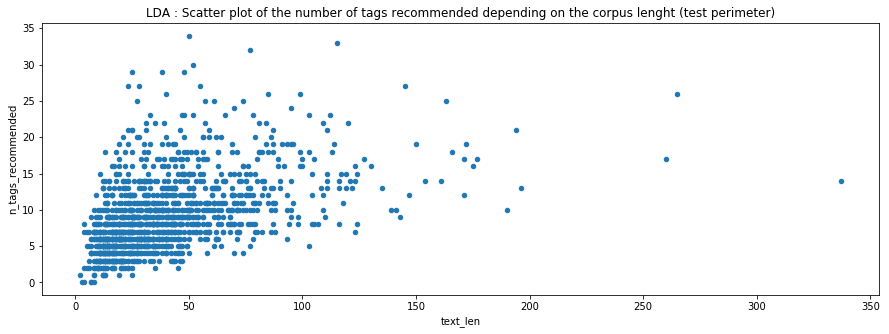

In [91]:
df_test.plot.scatter(x='text_len',
                     y='n_tags_recommended',
                     figsize=(15,5),
                     title = "LDA : Scatter plot of the number of tags recommended depending on the corpus lenght (test perimeter)")

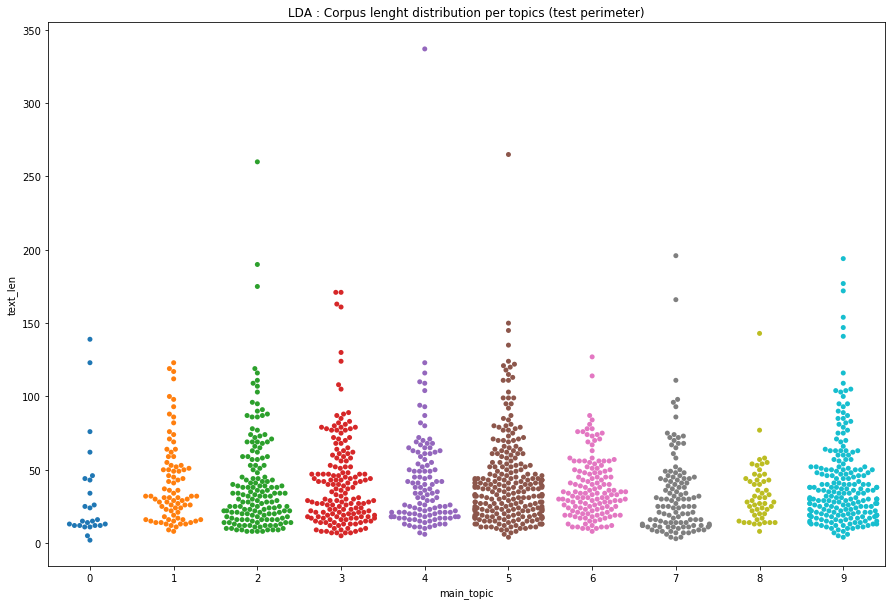

In [92]:
plt.figure(figsize=(15,10))
plt.title("LDA : Corpus lenght distribution per topics (test perimeter)")
ax = sns.swarmplot(x="main_topic", y="text_len", data=df_test)

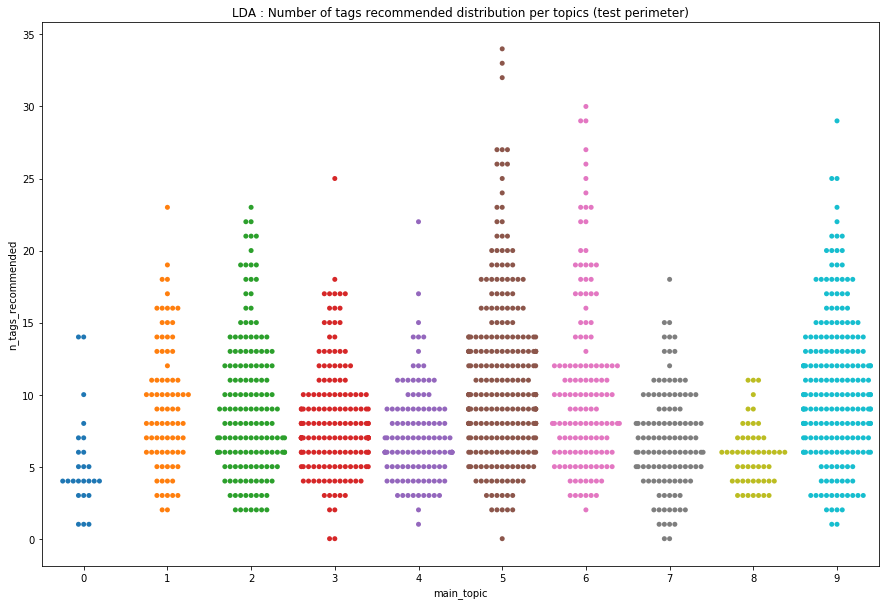

In [93]:
plt.figure(figsize=(15,10))
plt.title("LDA : Number of tags recommended distribution per topics (test perimeter)")
ax = sns.swarmplot(x="main_topic", y="n_tags_recommended", data=df_test)

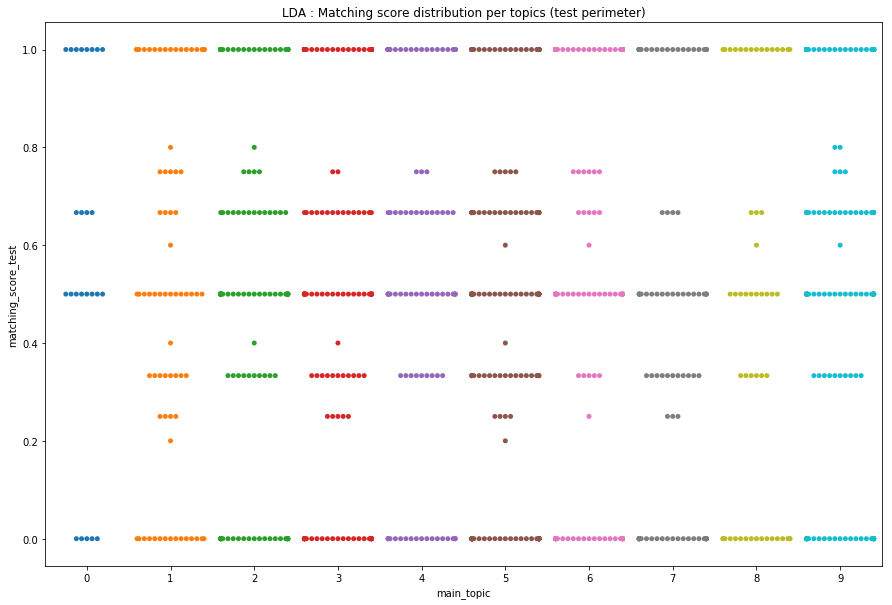

In [94]:
plt.figure(figsize=(15,10))
plt.title("LDA : Matching score distribution per topics (test perimeter)")
ax = sns.swarmplot(x="main_topic", y="matching_score_test", data=df_test)